## Imports 🙅🏻‍♂️🙅🏻‍♀️

In [45]:
import matplotlib
# !pip install opencv-python
import matplotlib.pyplot as ajeeb
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import image as mpimg
from matplotlib.pyplot import figure
import seaborn as sns
import numpy as np
%matplotlib inline
from scipy import linalg
from scipy.linalg import null_space
# !pip install imageio
import imageio

## TASK-02 (45 MARKS)🕷️

### Pre-Processing (2 Marks)
- Justify each step of your pre-processing in comments
- Save the final pre-process images to the same directory

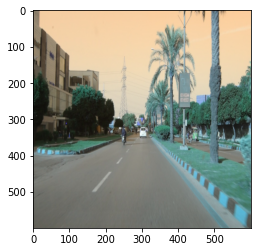

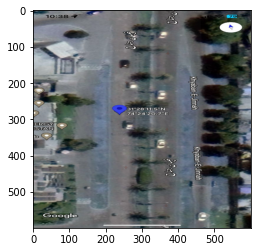

In [46]:
# Add your code here
# Load the two images
def normalize_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    normalize_image = cv2.normalize(gray_image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalize_image= cv2.resize(image, (600, 600))
    return normalize_image

image1 = cv2.imread('street.jpg')  
image2 = cv2.imread('aerial.jpg')

image1 = normalize_image(image1)
image2 = normalize_image(image2)

# Display the two images
# Add your code here
plt.imshow(image1)
plt.show()

plt.imshow(image2) 
plt.show()


### Reading image points

Load the first image you're about to stitch and mark some points that you find in the second image too. The `point_reader()` function from `StudentID_PA3.py` will be helpful.

### Reading the first image's points (4 Marks)

In [47]:
def point_reader(img):
    img_copy = img.copy()
    cv2.namedWindow("Mark Points")
    marked_points = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            marked_points.append((x, y))
            # Draw a circle at the clicked point
            cv2.circle(img_copy, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Mark Points", img_copy)

    cv2.setMouseCallback("Mark Points", click_event)
    cv2.imshow("Mark Points", img_copy)
    
    while len(marked_points) < 4:
        cv2.waitKey(1)     
    cv2.destroyAllWindows()

    marked_img_path = "marked_image.jpg"
    cv2.imwrite(marked_img_path, img_copy)


    points_array = np.array(marked_points)
    return points_array

In [48]:
# Save your points in an np.array
img1_points = point_reader(image1)
print(img1_points)

[[260 344]
 [ 70 420]
 [320 341]
 [437 452]]


### Reading the first image's points (4 Marks)

In [49]:
# Save your points in an np.array
img2_points = point_reader(image2)
print(img2_points)

[[216 205]
 [206 467]
 [278 209]
 [286 468]]


### Finding Homography (25 Marks)
You are required to calculate the homography matrix H.
$$
\begin{bmatrix}
x'  \\
y'  \\
h 
\end{bmatrix}
=
\begin{bmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{bmatrix}
\times 
\begin{bmatrix}
x  \\
y  \\
1 
\end{bmatrix}
$$
You can use the strategy from WA-1, Q#7 to solve this =)

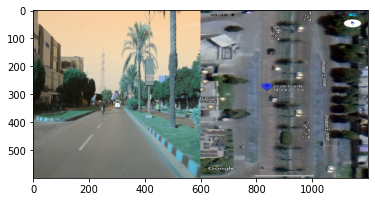

In [50]:
# We are creating the canvas which is essentially the two images joined together
row1, col1 = image1.shape[:2]
row2, col2 = image2.shape[:2]

canvas = np.zeros((max(row1, row2), col1 + col2, 3), dtype='uint8')

# We are placing the first image on the left side of the canvas
canvas[:row1, :col1, :] = image1
# We are placing the second image on the right side of the canvas
canvas[:row2, col1:col1 + col2, :] = image2


# Display the canvas
plt.imshow(canvas)

In [51]:
img2_points[:,0] = img2_points[:,0] + col1

In [52]:
# DUMP YOUR CODE
# We will now zip the points together
points = list(zip(img1_points, img2_points))

homoArray = []
for point1, point2 in points:
    homoArray.append([point1[0], point1[1], 1, 0, 0, 0, -point2[0] * point1[0], -point2[0] * point1[1], -point2[0]])
    homoArray.append([0, 0, 0, point1[0], point1[1], 1, -point2[1] * point1[0], -point2[1] * point1[1], -point2[1]])

homoArray = np.array(homoArray)
print(homoArray)

[[    260     344       1       0       0       0 -212160 -280704    -816]
 [      0       0       0     260     344       1  -53300  -70520    -205]
 [     70     420       1       0       0       0  -56420 -338520    -806]
 [      0       0       0      70     420       1  -32690 -196140    -467]
 [    320     341       1       0       0       0 -280960 -299398    -878]
 [      0       0       0     320     341       1  -66880  -71269    -209]
 [    437     452       1       0       0       0 -387182 -400472    -886]
 [      0       0       0     437     452       1 -204516 -211536    -468]]


### Calculating SVD
This part has been done for you 🙌🏻

In [53]:
# List of useful functions
u, s, vh = np.linalg.svd(homoArray) # Replace it with your H matrix
vh = np.transpose(vh)
P = vh[:,len(vh[0])-1]

P = np.array([P[0:3], P[3:6], P[6:9]])

np.save("homography_matrix.npy", P)
print("Homography matrix\n",P)

Homography matrix
 [[-2.59220578e-04 -2.42289113e-03  8.56392965e-01]
 [-9.61311011e-05 -1.46074425e-03  5.16315868e-01]
 [-2.32750439e-07 -2.79280892e-06  9.66732885e-04]]


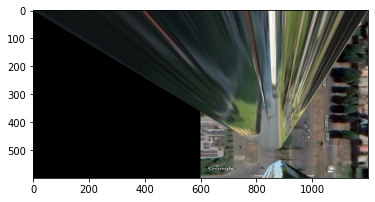

In [54]:
# YOUR CODE
stitchedImage = cv2.warpPerspective(image1, P, (canvas.shape[1], canvas.shape[0]))
stitchedImage[:, image1.shape[1]:, :] = np.where(stitchedImage[:, image1.shape[1]:, :] == 0, image2, stitchedImage[:, image1.shape[1]:, :])

plt.imshow(stitchedImage[:,:,::-1])

In [55]:
homography_matrix = np.load("homography_matrix.npy")
print(homography_matrix)

[[-2.59220578e-04 -2.42289113e-03  8.56392965e-01]
 [-9.61311011e-05 -1.46074425e-03  5.16315868e-01]
 [-2.32750439e-07 -2.79280892e-06  9.66732885e-04]]


In [56]:
# video_path = 'attempt1.mp4'
# output_folder = "Input Images"
# cap = cv2.VideoCapture(video_path)

# fps = int(cap.get(cv2.CAP_PROP_FPS))

# width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
# height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# video_writer = cv2.VideoWriter("output_video.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

# frame_count = 0

# while cap.isOpened():
#     ret, frame = cap.read()
#     if ret:
#         frame_count += 1
#         if frame_count % 10 == 0:
#             cv2.imwrite(output_folder + "/" + str(frame_count) + ".jpg", frame)
#             frame_count += 1
#         video_writer.write(frame)
#     else:
#         break

# frame_path = f"{output_folder}/frame_{frame_count}.jpg"
# cv2.imwrite(frame_path, frame)

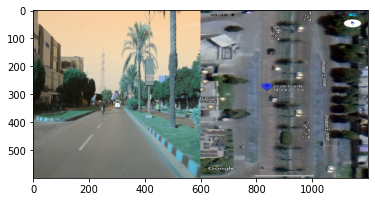

In [57]:
# We are creating the canvas which is essentially the two images joined together
row1, col1 = image1.shape[:2]
row2, col2 = image2.shape[:2]

canvas = np.zeros((max(row1, row2), col1 + col2, 3), dtype='uint8')

# We are placing the first image on the left side of the canvas
canvas[:row1, :col1, :] = image1
# We are placing the second image on the right side of the canvas
canvas[:row2, col1:col1 + col2, :] = image2


# Display the canvas
plt.imshow(canvas)

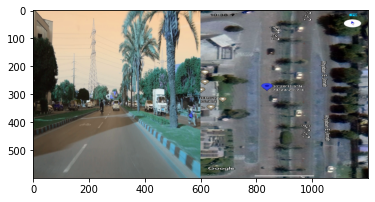

In [61]:
import os

input_folder = "Input Images"
output_folder = "Output Images"

if not os.path.exists(output_folder):     
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        img1 = cv2.imread(image_path)
        img2 = cv2.imread('aerial.jpg')
        img1 = normalize_image(img1)
        img2 = normalize_image(img2)


        row1, col1 = img1.shape[:2] 
        row2, col2 = img2.shape[:2]
        canvas = np.zeros((max(row1, row2), col1 + col2, 3), dtype='uint8')

        canvas[:row1, :col1, :] = img1
        canvas[:row2, col1:col1 + col2, :] = img2
        plt.imshow(canvas)
        img2_points[:,0] = img2_points[:,0] + col1
    
        warped_img = cv2.warpPerspective(img1, homography_matrix, (canvas.shape[1], canvas.shape[0]))
        warped_img[:, img1.shape[1]:, :] = np.where(warped_img[:, img1.shape[1]:, :] == 0, img2, warped_img[:, img1.shape[1]:, :])
        output_path = os.path.join(output_folder, f"warped_{filename}")
        cv2.imwrite(output_path, warped_img)